<a href="https://colab.research.google.com/github/ykitaguchi77/Strabismus_AI_project/blob/main/Hough_circle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Hough変換を用いた虹彩検出**
https://ipsj.ixsq.nii.ac.jp/ej/?action=repository_action_common_download&item_id=113806&item_no=1&attribute_id=1&file_no=1<br>
※HEICファイルには未対応。https://www.apowersoft.jp/heic-to-jpgで先に変換。

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torch.utils.data as data
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import pandas as pd

#Advanced Pytorchから
import glob
import os.path as osp
import random
import json
from PIL import Image
from tqdm import tqdm
%matplotlib inline

#サポートパッチのインポート
from google.colab.patches import cv2_imshow
import cv2

plt.ion()   # interactive mode
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab.patches import cv2_imshow
import cv2
import matplotlib.pyplot as plt
import math
from PIL import Image
import numpy as np
import dlib
from imutils import face_utils
import os

img_path = "/content/drive/MyDrive/Deep_learning/Face_Images/IMG_4087.JPG"

predictor_path = '/content/drive/My Drive/AI_laboratory_course/shape_predictor_68_face_landmarks.dat'
predictor = dlib.shape_predictor(predictor_path)
detector = dlib.get_frontal_face_detector()




# 画像読込み
img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
img2 = img.copy()

if img is None:
    print('画像が見つかりません')
    exit()

rects = detector(img, 1)
if len(rects) == 0:
    print('顔が抽出されませんでした')
    exit()

for rect in rects:
    for idx,p in enumerate(predictor(img,rect).parts()): 
        x = p.x
        y = p.y
        cv2.circle(img, (x,y),2, (0,255,0), thickness= 3)
        cv2.putText(img,str(idx) , (x + 3, y+3), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), thickness=1)

cv2_imshow(img)


dets = detector(img[:, :, ::-1])
parts = predictor (img, dets[0]).parts()

#眼周囲の画像を切り抜き
"""
x0 = int(parts[17].x)
x1 = int(parts[27].x) #両眼にするなら26で
y0 = int((parts[17].y + parts[26].y)/2)
y1 = int(parts[29].y)
"""
x0 = int(parts[36].x)
x1 = int(parts[39].x)
y0 = int(1.5*min(parts[37].y, parts[38].y)-0.5*max(parts[40].y, parts[41].y))
y1 = int(1.5*min(parts[40].y, parts[41].y)-0.5*max(parts[37].y, parts[38].y))

img3 = img2[y0 : y1, x0 : x1]
img4 = img3.copy()
img_copy0 = img3.copy()
img_copy1 = img3.copy()
img_copy2 = img3.copy()
img_copy3 = img3.copy()
img_copy4 = img3.copy()
cv2_imshow(img3)

#ガウシアンフィルター
#dst = cv2.GaussianBlur(img3, ksize=(3, 3), sigmaX=1.3)

#白黒化
gray = cv2.cvtColor(img4, cv2.COLOR_BGR2GRAY)
cv2_imshow(gray)


In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import hough_circle, hough_circle_peaks, hough_ellipse
from skimage.feature import canny
from skimage.draw import circle_perimeter, ellipse_perimeter
from skimage.color import rgb2gray
from skimage import data, color, img_as_ubyte
import matplotlib.patches as patches

#OTSUの2値化
ret, th = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU)
cv2_imshow(th)

#Canny法によるedge検出
edges = canny(th)
fig, ax = plt.subplots()
ax.imshow(edges, cmap=plt.cm.gray)

#ハフ変換による円検出
min_radius = int(1/5 * (parts[39].x - parts[36].x))
max_radius = int(2/3 * (parts[39].x - parts[36].x))
#min_radius = int(2/3 * (parts[41].y - parts[37].y))
#max_radius = int(2 * (parts[41].y - parts[37].y))

hough_radii = np.arange(min_radius, max_radius, 1)
hough_res = hough_circle(edges, hough_radii)
hough_res.shape
#(4, 400, 400)

#誤差が少なく近似されている円の選出
accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii,
                                           total_num_peaks=1) #数字を増やすと検出する円の種類を増やせる
print(accums)
print(cx)
print(cy)
print(radii)


#結果の表示
fig, ax = plt.subplots()

# Draw the most prominent 1 circles
image = color.gray2rgb(img3)
for center_y, center_x, radius in zip(cy, cx, radii):
    circy, circx = circle_perimeter(center_y, center_x, radius,
                                    shape=image.shape)
    image[circy, circx] = (220, 20, 20)

ax.imshow(image, cmap=plt.cm.gray)
plt.show()

In [ ]:
h, w = img4.shape[:2]
#print(h)
#print(w)
print("center_y: "+str(center_y))
print("center_x: "+str(center_x))
print("radius: "+str(radius))

# マスク作成 (黒く塗りつぶす画素の値は0)
mask = np.zeros((h, w), dtype=np.uint8)
# 円を描画する関数 circle() を利用してマスクの残したい部分を 255 にしている。
cv2.circle(mask, center=(center_x, center_y), radius=radius, color=255, thickness=-1)

# マスクを描画
plt.imshow(mask, cmap='gray')
plt.axis('off')
#plt.show()

img4[mask==0] = [0, 0, 0]  # mask の値が 0 の画素は黒で塗りつぶす。
plt.imshow(cv2.cvtColor(img4, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [ ]:
hsv = cv2.cvtColor(img4, cv2.COLOR_BGR2HSV)

# 白のHSV範囲
lower_white = np.array([0,0,200])
upper_white = np.array([180,45,255])

mask_white = cv2.inRange(hsv, lower_white, upper_white)
res_white = cv2.bitwise_and(img4, img4, mask= mask_white)

plt.imshow(res_white)
plt.axis('off')
plt.show()
 


In [22]:
res_white_WB = cv2.cvtColor(res_white, cv2.COLOR_BGR2GRAY)

In [32]:
contours, hierarchy = cv2.findContours(
    res_white_WB, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
)

# 小さい輪郭は誤検出として削除する
contours = list(filter(lambda x: cv2.contourArea(x) > 1, contours))

cv2.drawContours(img, contours, -1, color=(0, 0, 255), thickness=2)

for i, cnt in enumerate(contours):
    print(f"contours[{i}].shape: {cnt.shape}")


contours[0].shape: (7, 1, 2)
contours[1].shape: (4, 1, 2)


In [51]:
k=0
for c in contours:
    k+=1
    mu = cv2.moments(c)
    x,y= int(mu["m10"]/mu["m00"]) , int(mu["m01"]/mu["m00"])
    print("reflex"+str(k)+": x="+str(x)+", y="+str(y))

print(img4.shape)


reflex1: x=218, y=160
reflex2: x=194, y=71
(216, 396, 3)


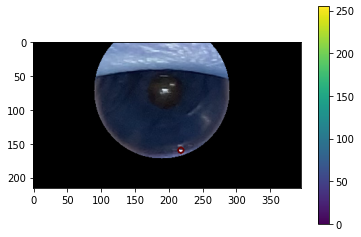

218 160


In [47]:
maxCont = contours[1]
for c in contours:
  if len(maxCont)<len(c):
    maxCont=c
 
mu = cv2.moments(maxCont)
x,y= int(mu["m10"]/mu["m00"]) , int(mu["m01"]/mu["m00"])

cv2.circle(img4, (x,y), 4, 100, 2, 4)
plt.imshow(img4)
plt.colorbar()
plt.show()

print(x,y)

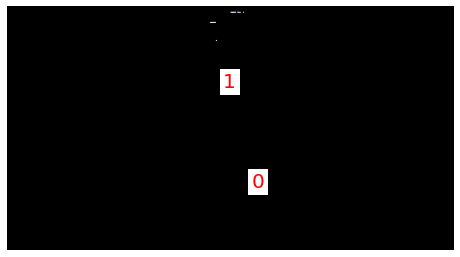

In [46]:
def draw_contours(ax, img, contours):
    ax.imshow(img)
    ax.set_axis_off()

    for i, cnt in enumerate(contours):
        # 形状を変更する。(NumPoints, 1, 2) -> (NumPoints, 2)
        cnt = cnt.squeeze(axis=1)
        # 輪郭の点同士を結ぶ線を描画する。
        ax.add_patch(plt.Polygon(cnt, color="b", fill=None, lw=2))
        # 輪郭の点を描画する。
        ax.plot(cnt[:, 0], cnt[:, 1], "ro", mew=0, ms=4)
        # 輪郭の番号を描画する。
        ax.text(cnt[0][0], cnt[0][1], i, color="r", size="20", bbox=dict(fc="w"))


fig, ax = plt.subplots(figsize=(8, 8))
draw_contours(ax, res_white, contours)

plt.show()